### This notebook includes the entire pipeline for the analysis after the necessary preprocessing that creates a (2040, 2639) feature matrix. At a high level, this notebook tunes a given classifier for predicting whether a speech recording is indicative of a speech disorder (0: Benign, 1: Anomalous). Then, the tuned classifier is used to predict instances within the test (hold out) set. ROC curves, Precision, Recall, and F-1 scores are also calculated outside of accuracy. Lastly, we interpret the constructed model through permutation importance, shapley importance, and partial dependency plots.

### Note: The results of the RCEFV with a simple random forests classifier are not shown here (a simple subset is created based on the results in the second code cell), although the process was a straightforward recursive feature elimination using a random forests model with default hyperparameters and step size of 1. Additionally, feature pruning based on correlation is conducted only to better improve interpretability (e.g., permutation feature importance is heavily influenced by highly correlated features). This additional reduction of features based on collinearity allows for better interpretability of the model at the cost of a slight predictive capability decrease.

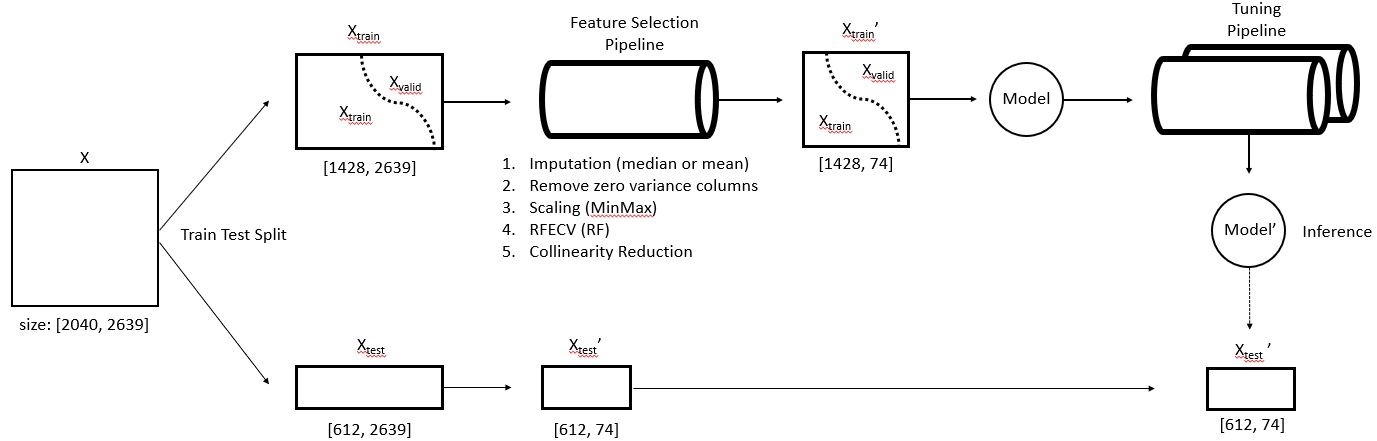

In [34]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, RFECV
from sklearn.metrics import accuracy_score, classification_report
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from pylab import rcParams
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score
import pickle

rcParams['figure.figsize'] = 10, 10
rcParams['figure.dpi'] = 300
rcParams['font.size'] = 10

#### Read in data, and then subset based on RFECV results using a default RandomForestClassifier(). Import data and drop a few features.

In [35]:
X = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\Complete_Feature_Set_11_19_2.csv')
y, age, sex, recording_num = X['y'], X['age'], X['sex'], X['recording_num']
X = X.drop(['y','age','sex','recording_num'], axis = 1)
num_feats_prior = X.shape[1]

rfecv_subset = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\RFECV_Results_12_8.csv')
X = X.loc[:, rfecv_subset.columns]
num_feats_after = X.shape[1]
print('Total number of features dropped was... ', num_feats_prior - num_feats_after, '\nRemaining features... ', num_feats_after)

Total number of features dropped was...  2535 
Remaining features...  104


#### Assess correlation between features, and drop individual features if they correlate highly (r > .75 chosen here) with any other features.

In [3]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X = X.drop(X[to_drop], axis=1)
print('Total number of features dropped was...', num_feats_after - X.shape[1], '\nRemaining features... ', X.shape[1])

Total number of features dropped was... 29 
Remaining features...  75


In [4]:
X = X.drop('high_indexphrase_features', axis = 1)

In [5]:
X.columns = ['Stdev Period l-a', 'Stdev MFCC-7 l-a', 'Mean Slope Melspec l-a', 'Mean Harmonicity l-a', 'Jitter (loc) h-a',
'Mean Slope Melspec h-a', 'Jitter (rap) lhl-a', 'Mean MFCC-2 lhl-a', 'Mean MFCC-7 lhl-a', 
'Stdev MFCC-2 lhl-a', 'Stdev Onset Envelope lhl-a', 'Stdev Pitches lhl-a', 'Mean Frequency n-a',
'Mean MFCC-8 n-a', 'LPC-1 n-a', 'Mean Slope Melspec n-a', 'Spec Power 1000Hz .25s n-a',
'Jitter (loc) l-i', 'Shimmer (apq11) l-i', 'Mean Magnitudes l-i', 'Mean Chromagram-4 l-i', 'Stdev Chromagram-4 l-i',
'Mean Slope (Hz) l-i', 'Mean MFCC-6 h-i', 'Mean Magnitudes h-i', 'Mean Slope (Hz) h-i', 'Mean MFCC-9 lhl-i',
'Mean Magnitudes lhl-i', 'Mean Harmony lhl-i', 'Mean Chromagram-0 n-i', 'Mean Slope Melspec n-i', 'Stdev Period l-u',
'Mean MFCC-4 l-u', 'Mean Slope (Hz) l-u', 'Mean Slope Melspec h-u', 'Mean MFCC-4 lhl-u', 'Mean Onset Envelope lhl-u',
'Stdev MFCC Delta-5 lhl-u', 'Stdev MFCC Delta-10 lhl-u', 'Stdev Period n-u', 'Mean Slope (Hz) n-u', 'HNR Phrases',
'Count of Periods Phrases', 'Mean MFCC-2 Phrases', 'Mean MFCC Delta-3 Phrases', 'Mean MFCC Delta-4 Phrases', 
'Mean MFCC Delta-11 Phrases', 'Stdev MFCC-2 Phrases', 'Stdev Onset Envelope Phrases', 'Max RMS Phrases',
'Stdev MFCC Delta-3 Phrases', 'Stdev MFCC Delta-7 Phrases', 'Spec Power 1000Hz .25s Phrases',
'Spec Power 1000Hz .5s Phrases','Spec Power 1000Hz .75s Phrases', 'CPPS Phrases', 'LSF-0 l-a', 
'Spectral Flux Stdev lhl-a', 'Spectral Spread Mean lhl-a', 'Spectral Spread Mean n-i',
'Shannon Entropy Sliding Window First Deriv Stdev n-i', 'f2 l-i', 'Spectral Skewness Mean h-i', 'Crest Factor Mean n-u',
'Pitch Period Entropy l-u', 'Spectral Flux First Deriv Mean Phrases', 'Spectral Entropy First Deriv Stdev Phrases',
'Spectral Spread Mean Phrases', 'Spectral Skewness First Deriv Stdev Phrases', 'Spectral Flatness Stdev Phrases', 
'Spectral Rolloff Stdev Phrases', 'Pitch Period Entropy Phrases', 'LPC-4 Phrases', 'Kurtosis Sliding Window First Deriv Mean Phrases']

#### Split data and conduct an initial fit prior to hyperparameter tuning.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify = y, random_state = 42)

classifier = KNeighborsClassifier()

test_pipeline = Pipeline([('variance_pruning', VarianceThreshold()),
                ('imputer', KNNImputer()), 
                ('scaler', MinMaxScaler()),
                ('model', classifier)])

test_pipeline.fit(X_train, y_train)
print(classification_report(y_test, test_pipeline.predict(X_test), target_names = ['benign','anomalous'], digits = 4))

              precision    recall  f1-score   support

      benign     0.6743    0.7136    0.6934       206
   anomalous     0.8503    0.8251    0.8375       406

    accuracy                         0.7876       612
   macro avg     0.7623    0.7694    0.7654       612
weighted avg     0.7910    0.7876    0.7890       612



#### Conducted hyperparameter tuning using RandomizedSearchCV and the already constructed pipeline. 

In [7]:
search_space = [{'model': [KNeighborsClassifier()],
                 'model__n_neighbors': [30,50,70,90,110,130,150],
                 'model__weights': ['uniform', 'distance'],
                 'model__algorithm': ['auto','ball_tree','kd_tree','brute'],
                 'model__leaf_size': [20,30,40,50],
                 'model__p':[1,2],
                 'model__n_jobs':[-1]}]

clf = RandomizedSearchCV(test_pipeline, search_space, cv = 5, verbose = 0, n_jobs = -1,\
                        scoring = 'roc_auc', n_iter = 100) 

clf = clf.fit(X_train, y_train) 

print('Best score of a given tuned classifier during the randomized search...', clf.best_score_*100)

Best score of a given tuned classifier during the randomized search... 87.96934938290744


#### Fetch best estimator found during the tuning process, and finally use this estimator to predict cases in the testing set. Calculate precision, recall, and f1-score across the two classes.

In [8]:
tuned_clf = clf.best_estimator_

print(classification_report(y_test, tuned_clf.predict(X_test), target_names = ['benign','anomalous'], digits = 4))
print(accuracy_score(y_test, tuned_clf.predict(X_test)))

              precision    recall  f1-score   support

      benign     0.7290    0.7573    0.7429       206
   anomalous     0.8744    0.8571    0.8657       406

    accuracy                         0.8235       612
   macro avg     0.8017    0.8072    0.8043       612
weighted avg     0.8254    0.8235    0.8243       612

0.8235294117647058


In [9]:
print(clf.best_params_)

{'model__weights': 'distance', 'model__p': 1, 'model__n_neighbors': 90, 'model__n_jobs': -1, 'model__leaf_size': 40, 'model__algorithm': 'brute', 'model': KNeighborsClassifier(algorithm='brute', leaf_size=40, n_jobs=-1, n_neighbors=90,
                     p=1, weights='distance')}


#### Create a receiver operating characteristic (ROC) curve and derive area under the curve (AUC).

C:\Users\esabic\Anaconda3\envs\gpu_environment\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(*args, **kw)>

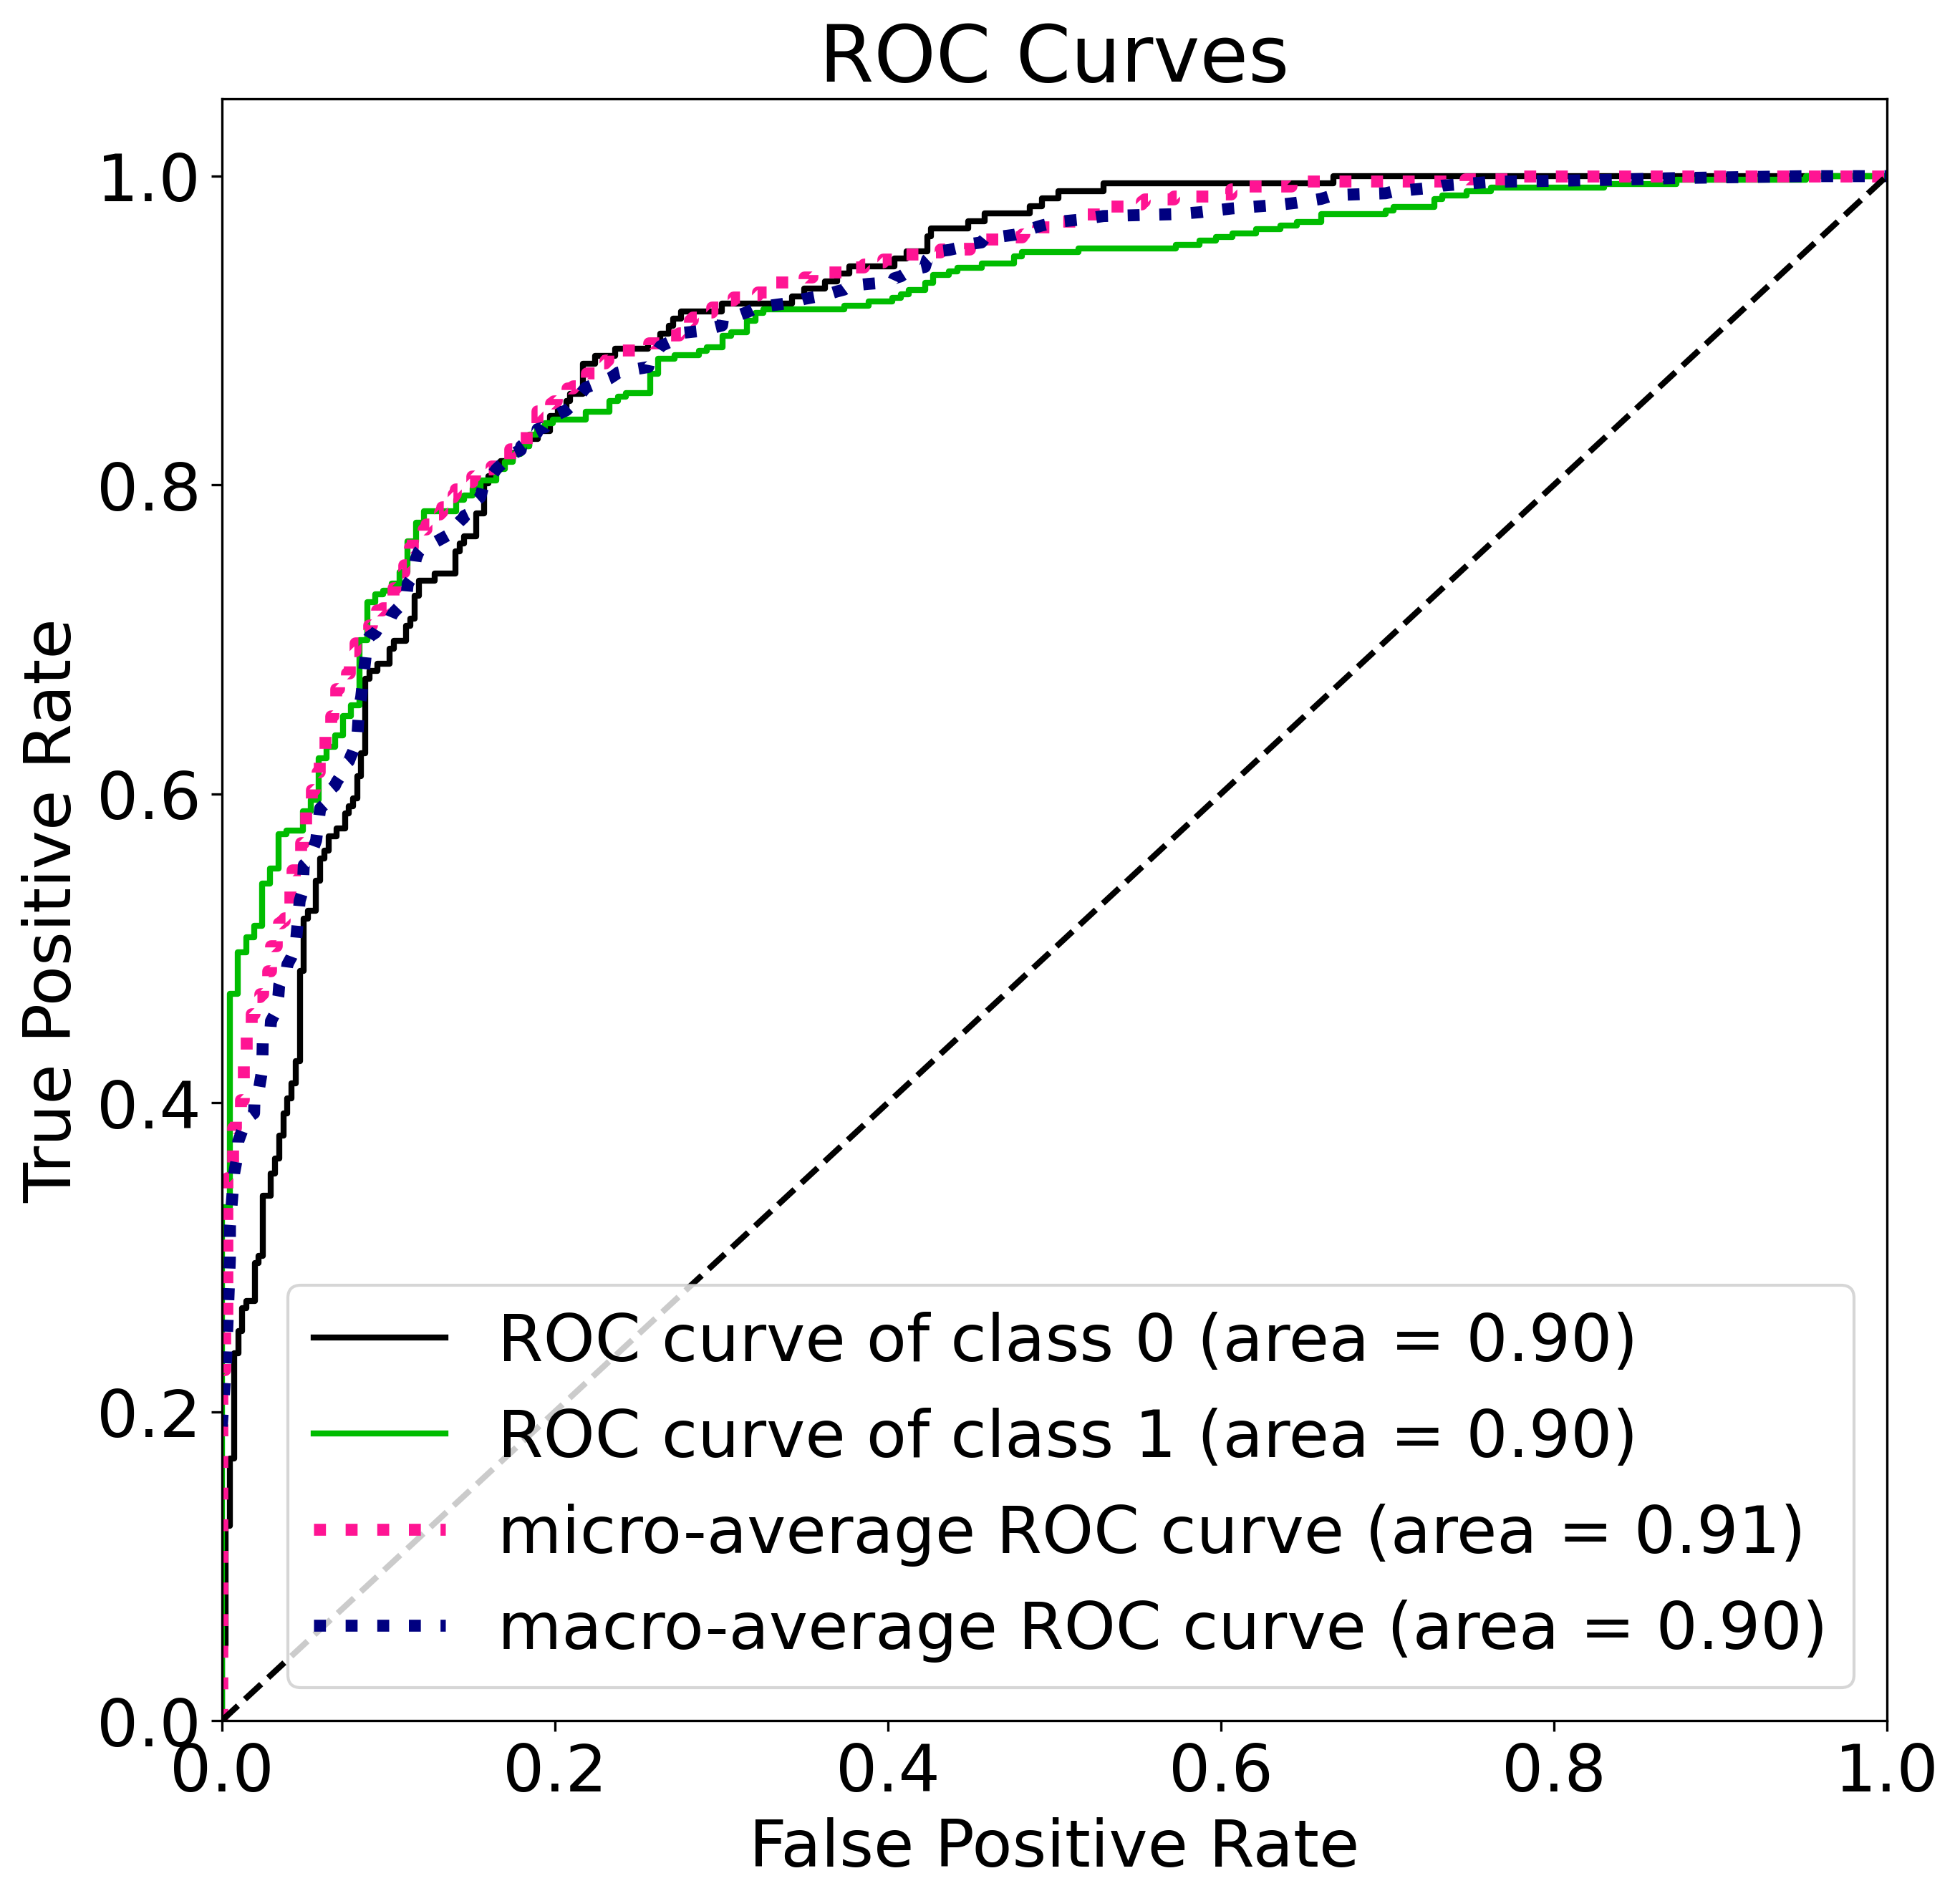

In [10]:
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt

rcParams['font.size'] = 22

y_true = y_test
y_probas = tuned_clf.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)

plt.show

#### Conduct permutation importance, Shapley-based importance, and create partial dependency plots using the highly influential features.

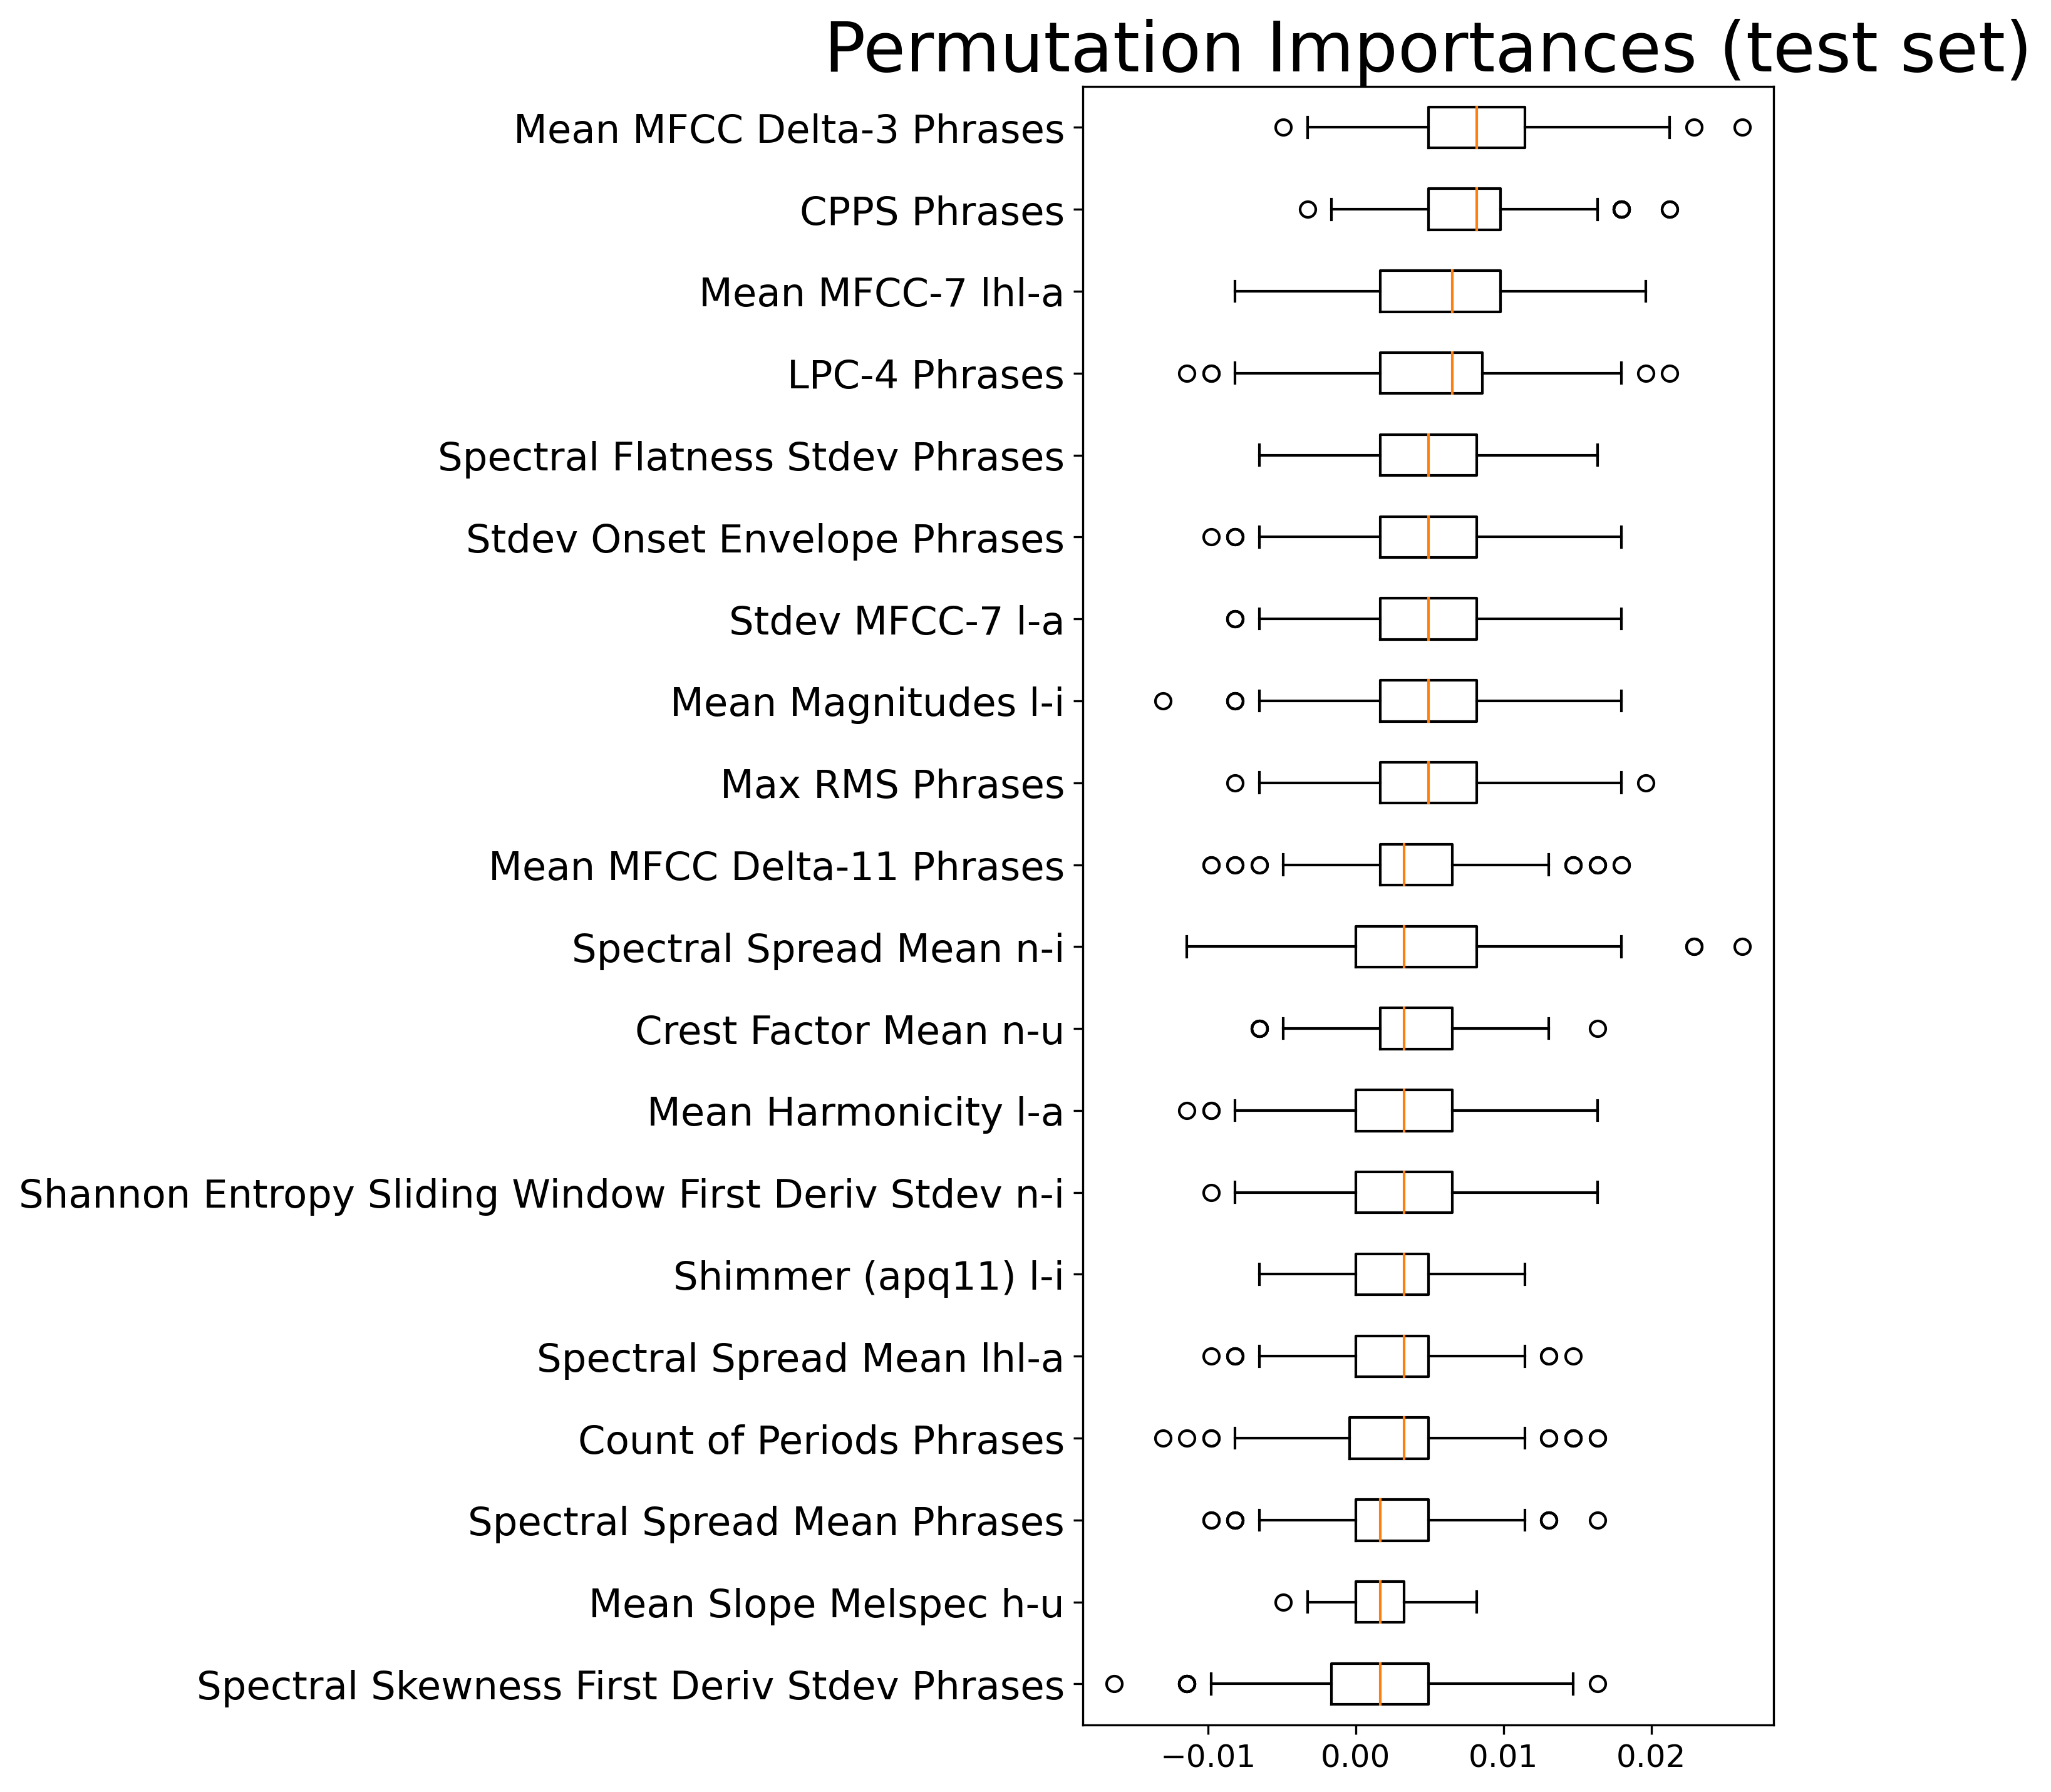

In [11]:
import matplotlib
from sklearn.inspection import permutation_importance

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=15) 

result = permutation_importance(tuned_clf, X_test, y_test, n_repeats = 500, 
                                random_state = 42, n_jobs = -1)

sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots()

ax.boxplot(result.importances[sorted_idx][-20:].T,
           vert=False, labels=X_test.columns[sorted_idx][-20:])

ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Permutation explainer: 613it [12:58,  1.28s/it]                                                                        


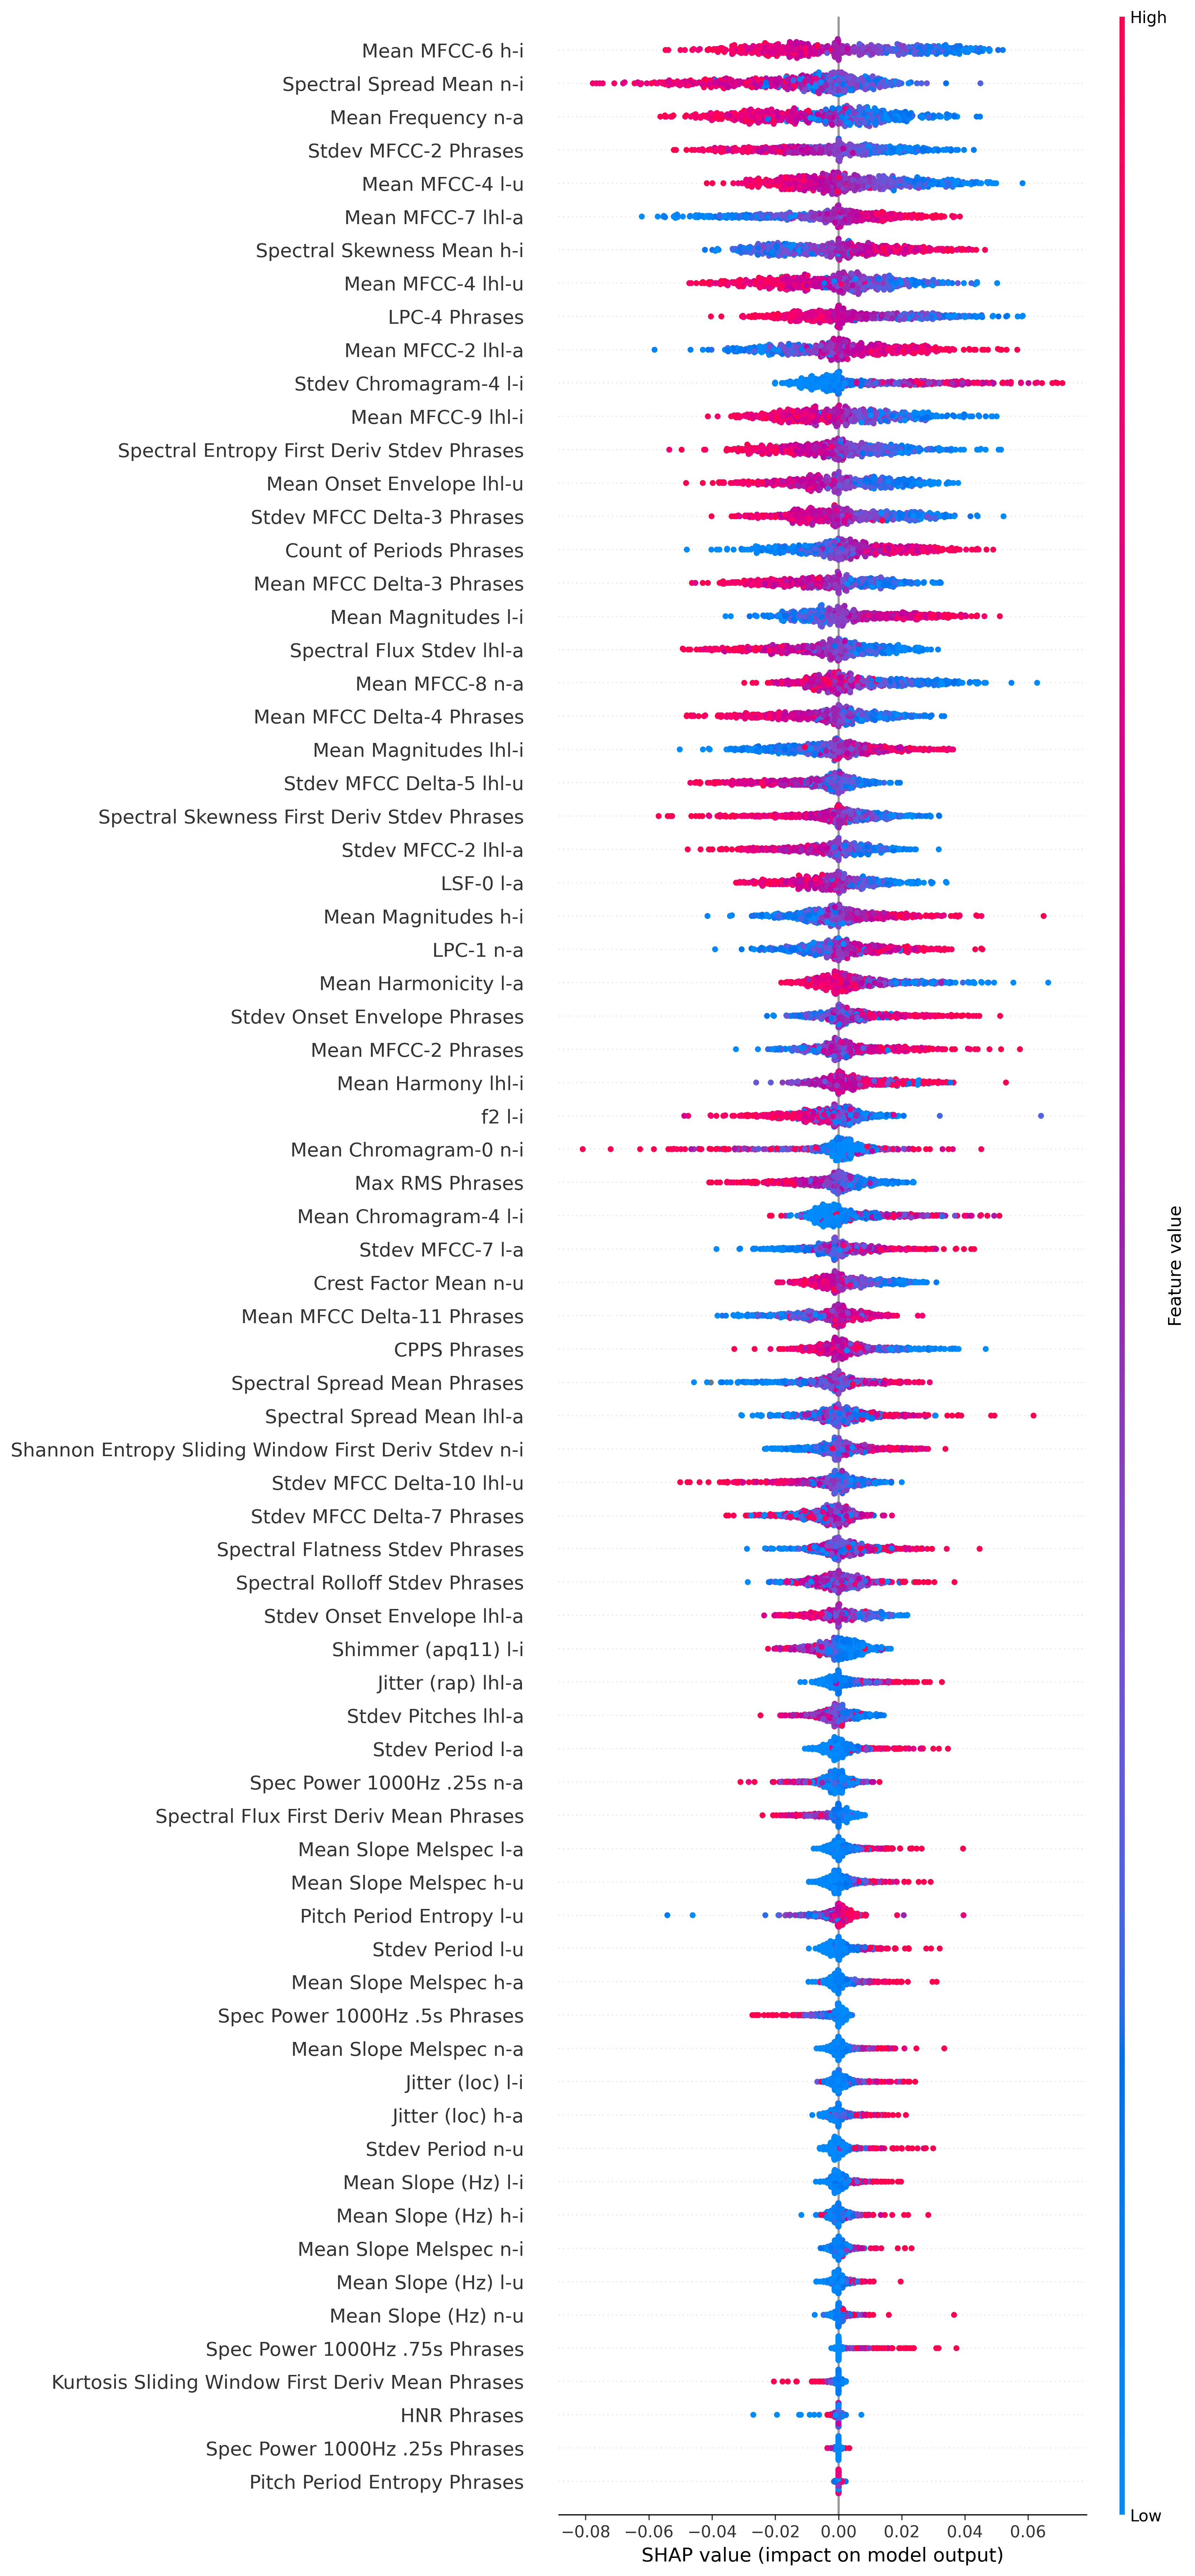

In [12]:
import shap

f = lambda x: tuned_clf.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test.iloc[:,:])

shap.plots.beeswarm(shap_values)

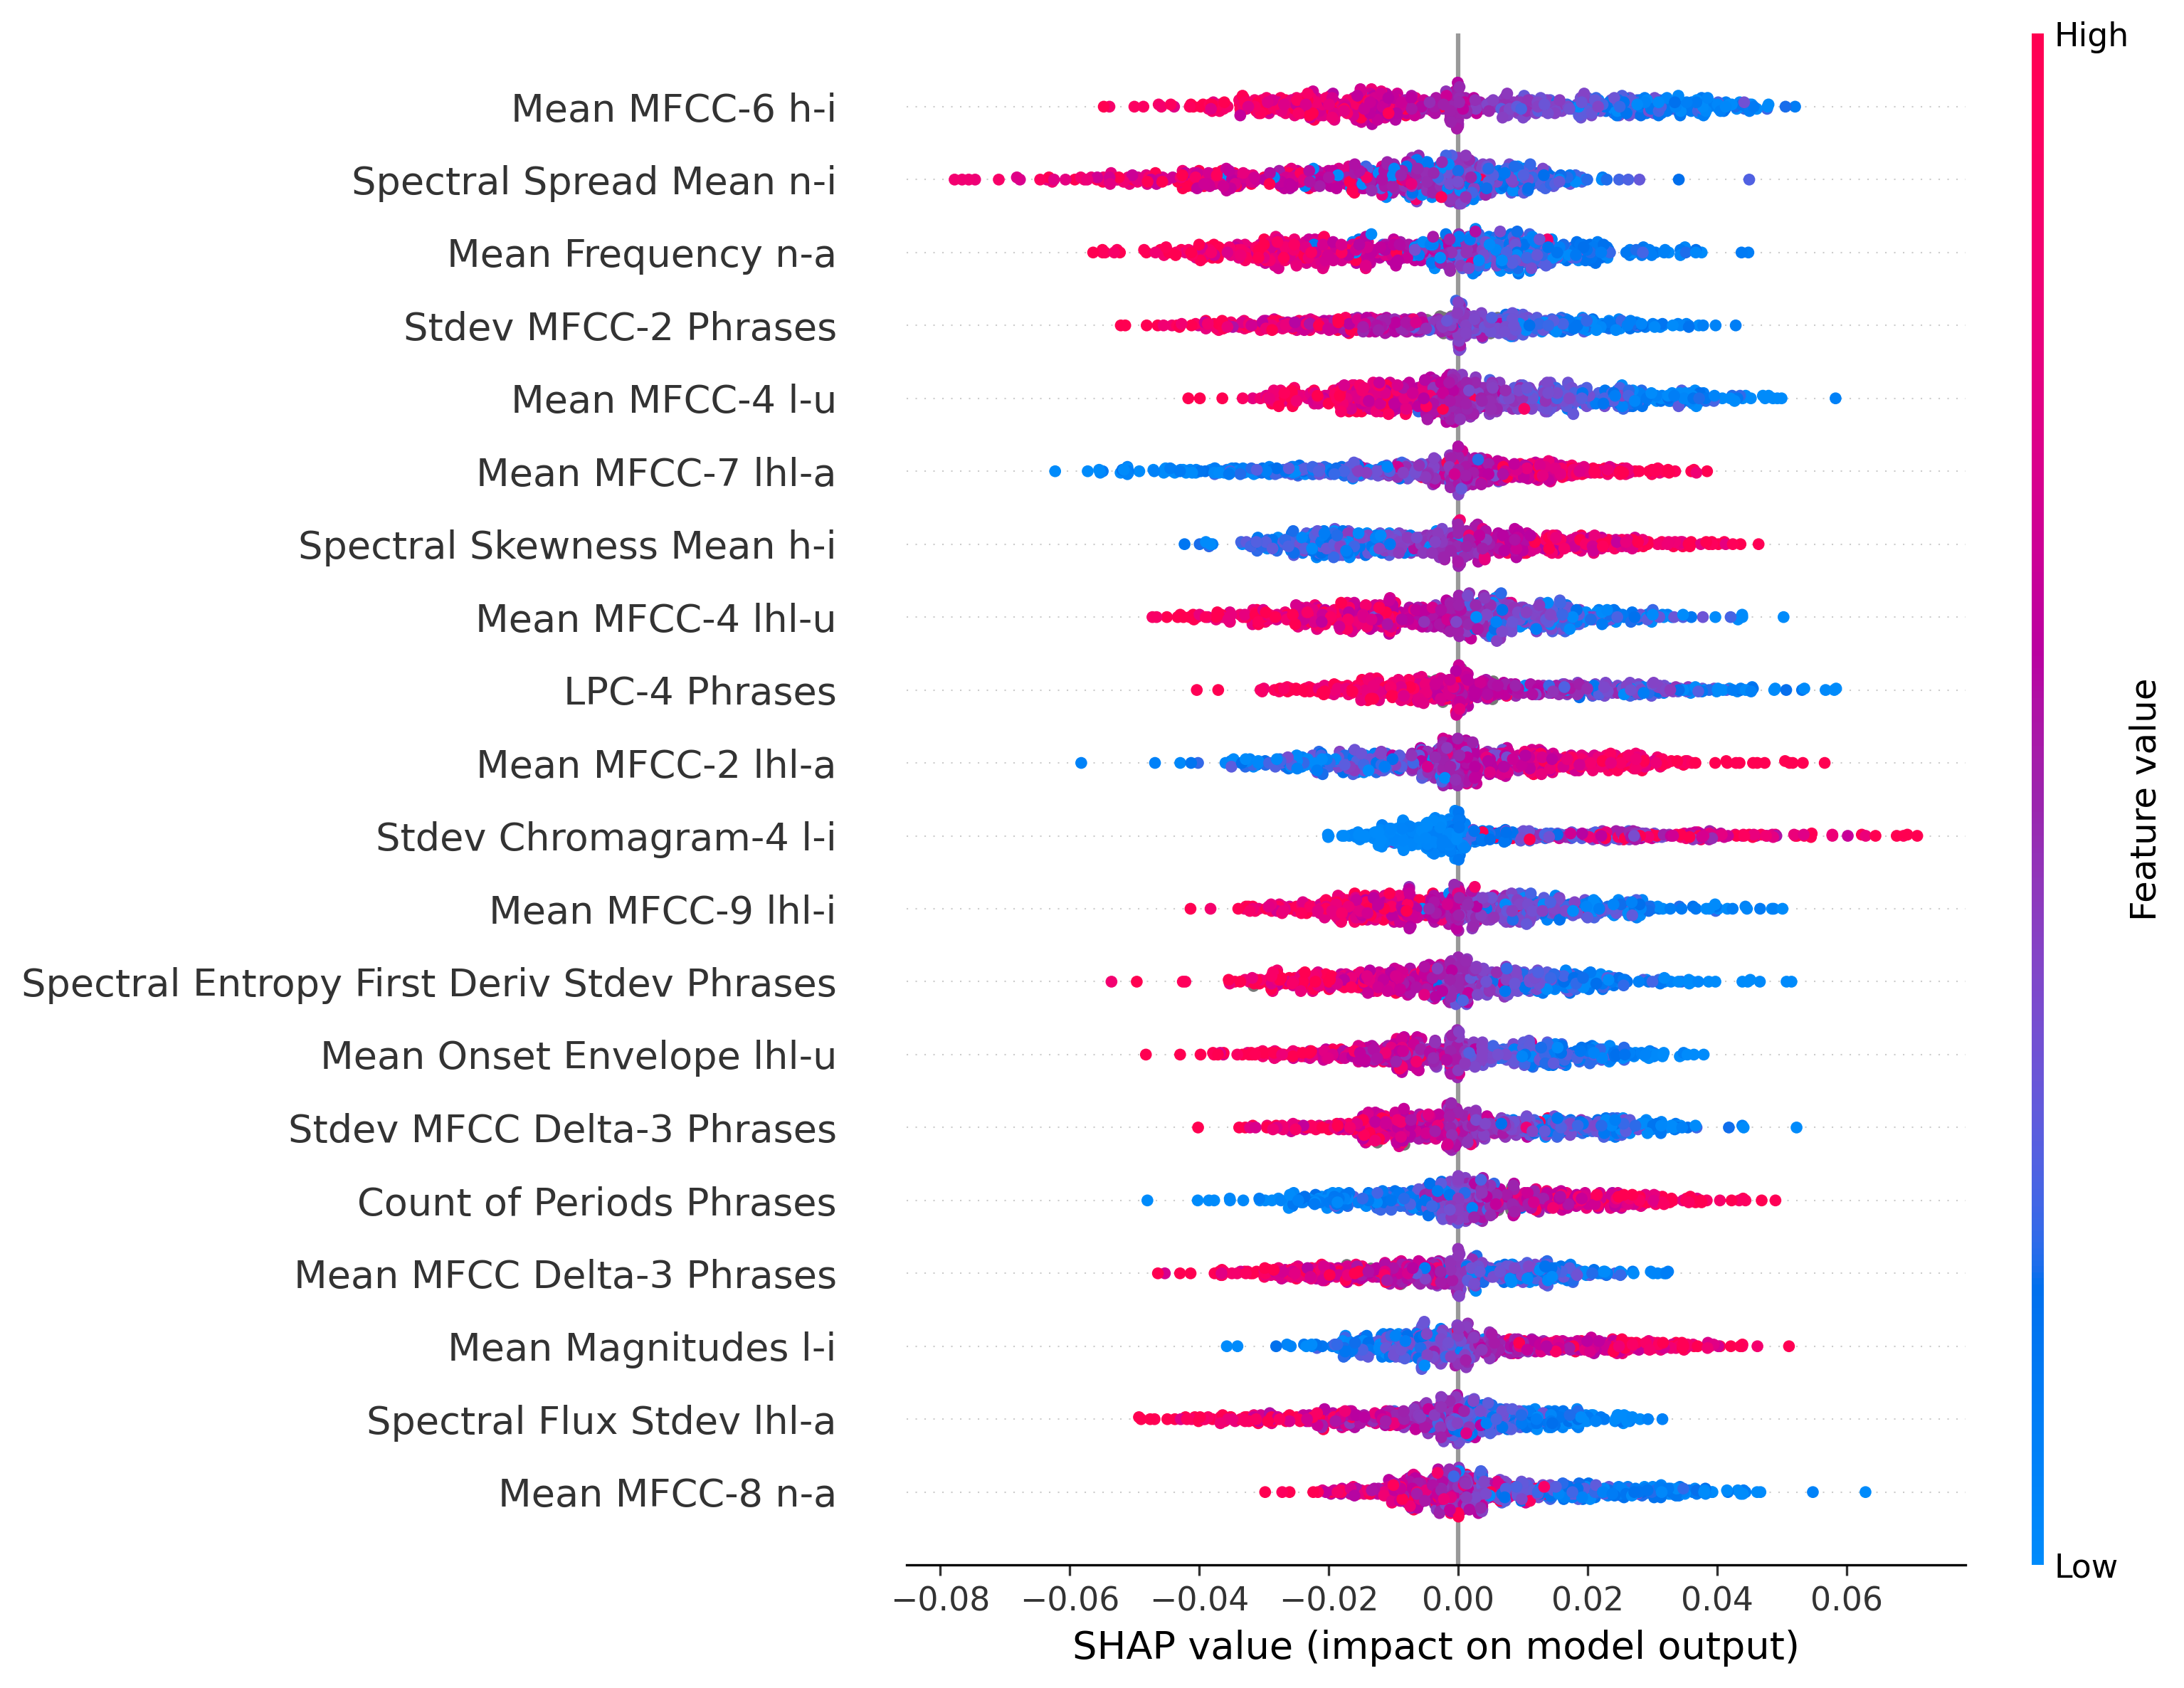

In [13]:
top = ['Mean MFCC-6 h-i', 'Spectral Spread Mean n-i', 'Mean Frequency n-a', 'Stdev MFCC-2 Phrases', 'Mean MFCC-4 l-u',
      'Mean MFCC-7 lhl-a', 'Spectral Skewness Mean h-i', 'Mean MFCC-4 lhl-u', 'LPC-4 Phrases', 'Mean MFCC-2 lhl-a',
      'Stdev Chromagram-4 l-i', 'Mean MFCC-9 lhl-i', 'Spectral Entropy First Deriv Stdev Phrases', 'Mean Onset Envelope lhl-u',
      'Stdev MFCC Delta-3 Phrases', 'Count of Periods Phrases', 'Mean MFCC Delta-3 Phrases', 'Mean Magnitudes l-i',
      'Spectral Flux Stdev lhl-a', 'Mean MFCC-8 n-a']

top_loc=[X.columns.get_loc(c) for c in top if c in X]
shap.plots.beeswarm(shap_values[:,top_loc])

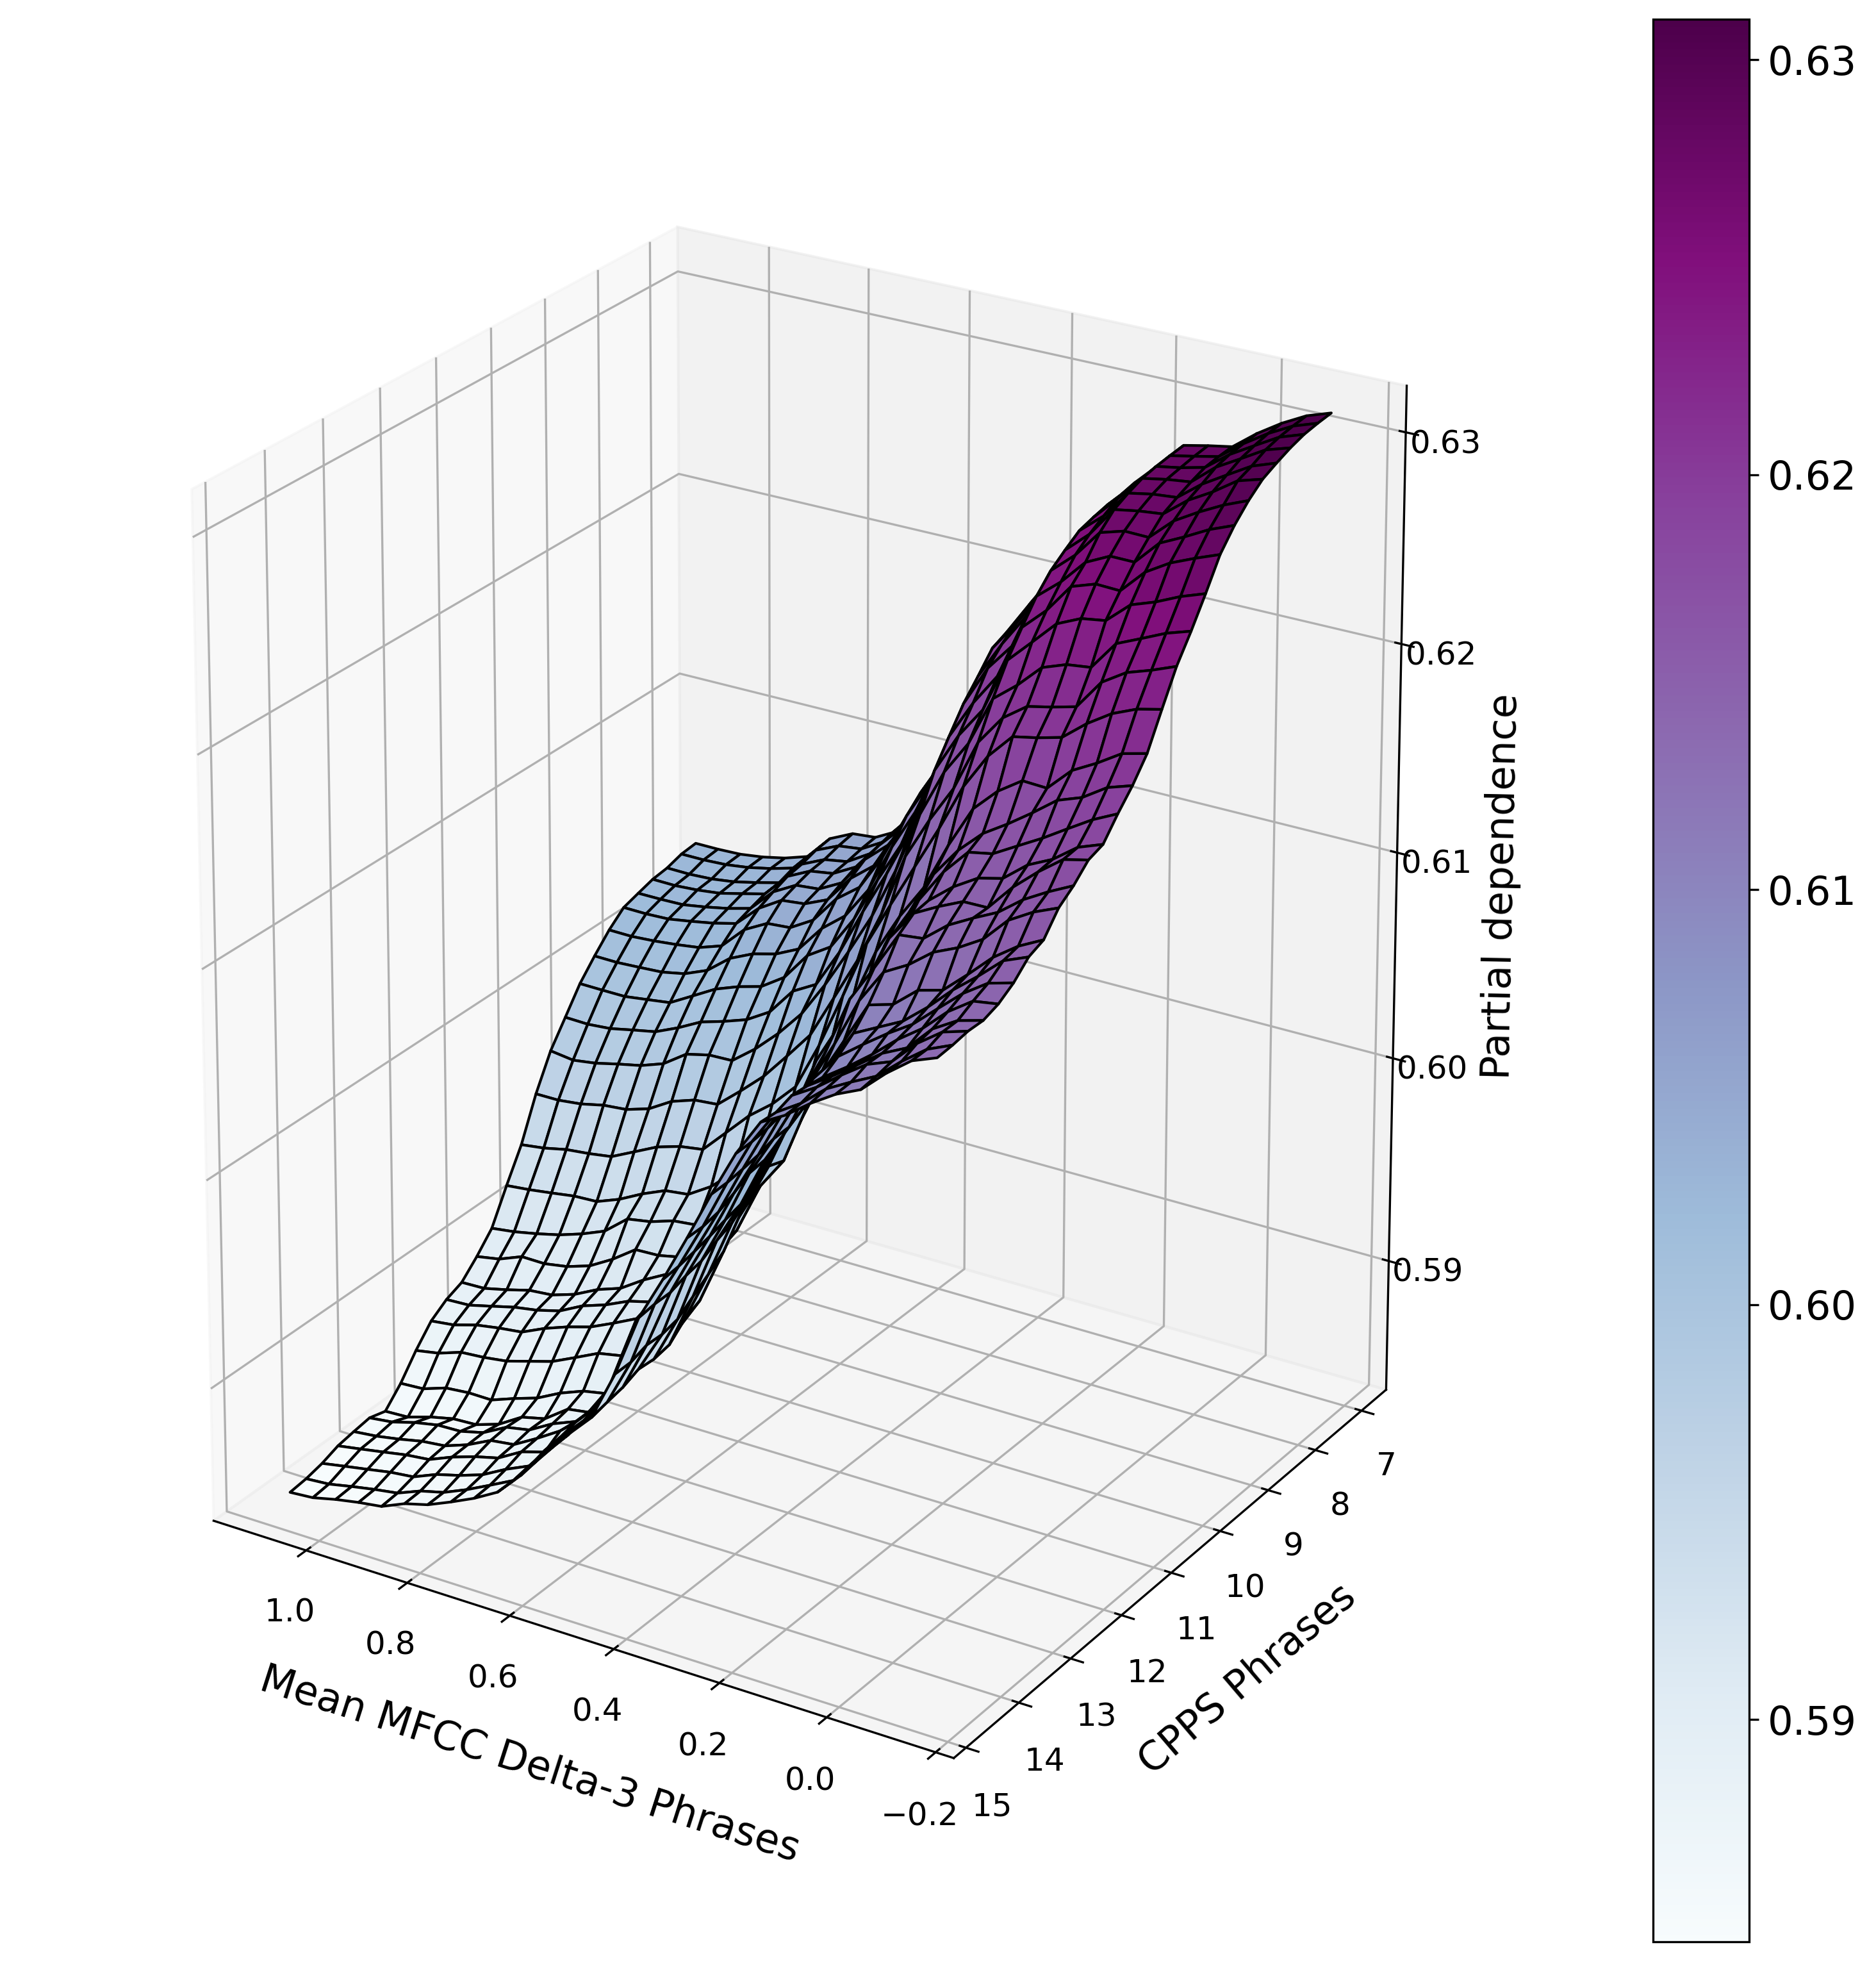

In [14]:
from sklearn.inspection import partial_dependence, plot_partial_dependence
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
rcParams['font.size'] = 15
fig = plt.figure()

features = ('Mean MFCC Delta-3 Phrases', 'CPPS Phrases')
pdp = partial_dependence(
    tuned_clf, X_test, kind = 'average', features=features, grid_resolution=28
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0], labelpad = 10)
ax.set_ylabel(features[1], labelpad = 10)
ax.set_zlabel('Partial dependence', labelpad = 10)

ax.view_init(elev=20, azim=122)
plt.colorbar(surf)

plt.subplots_adjust(top=0.9)
plt.show()

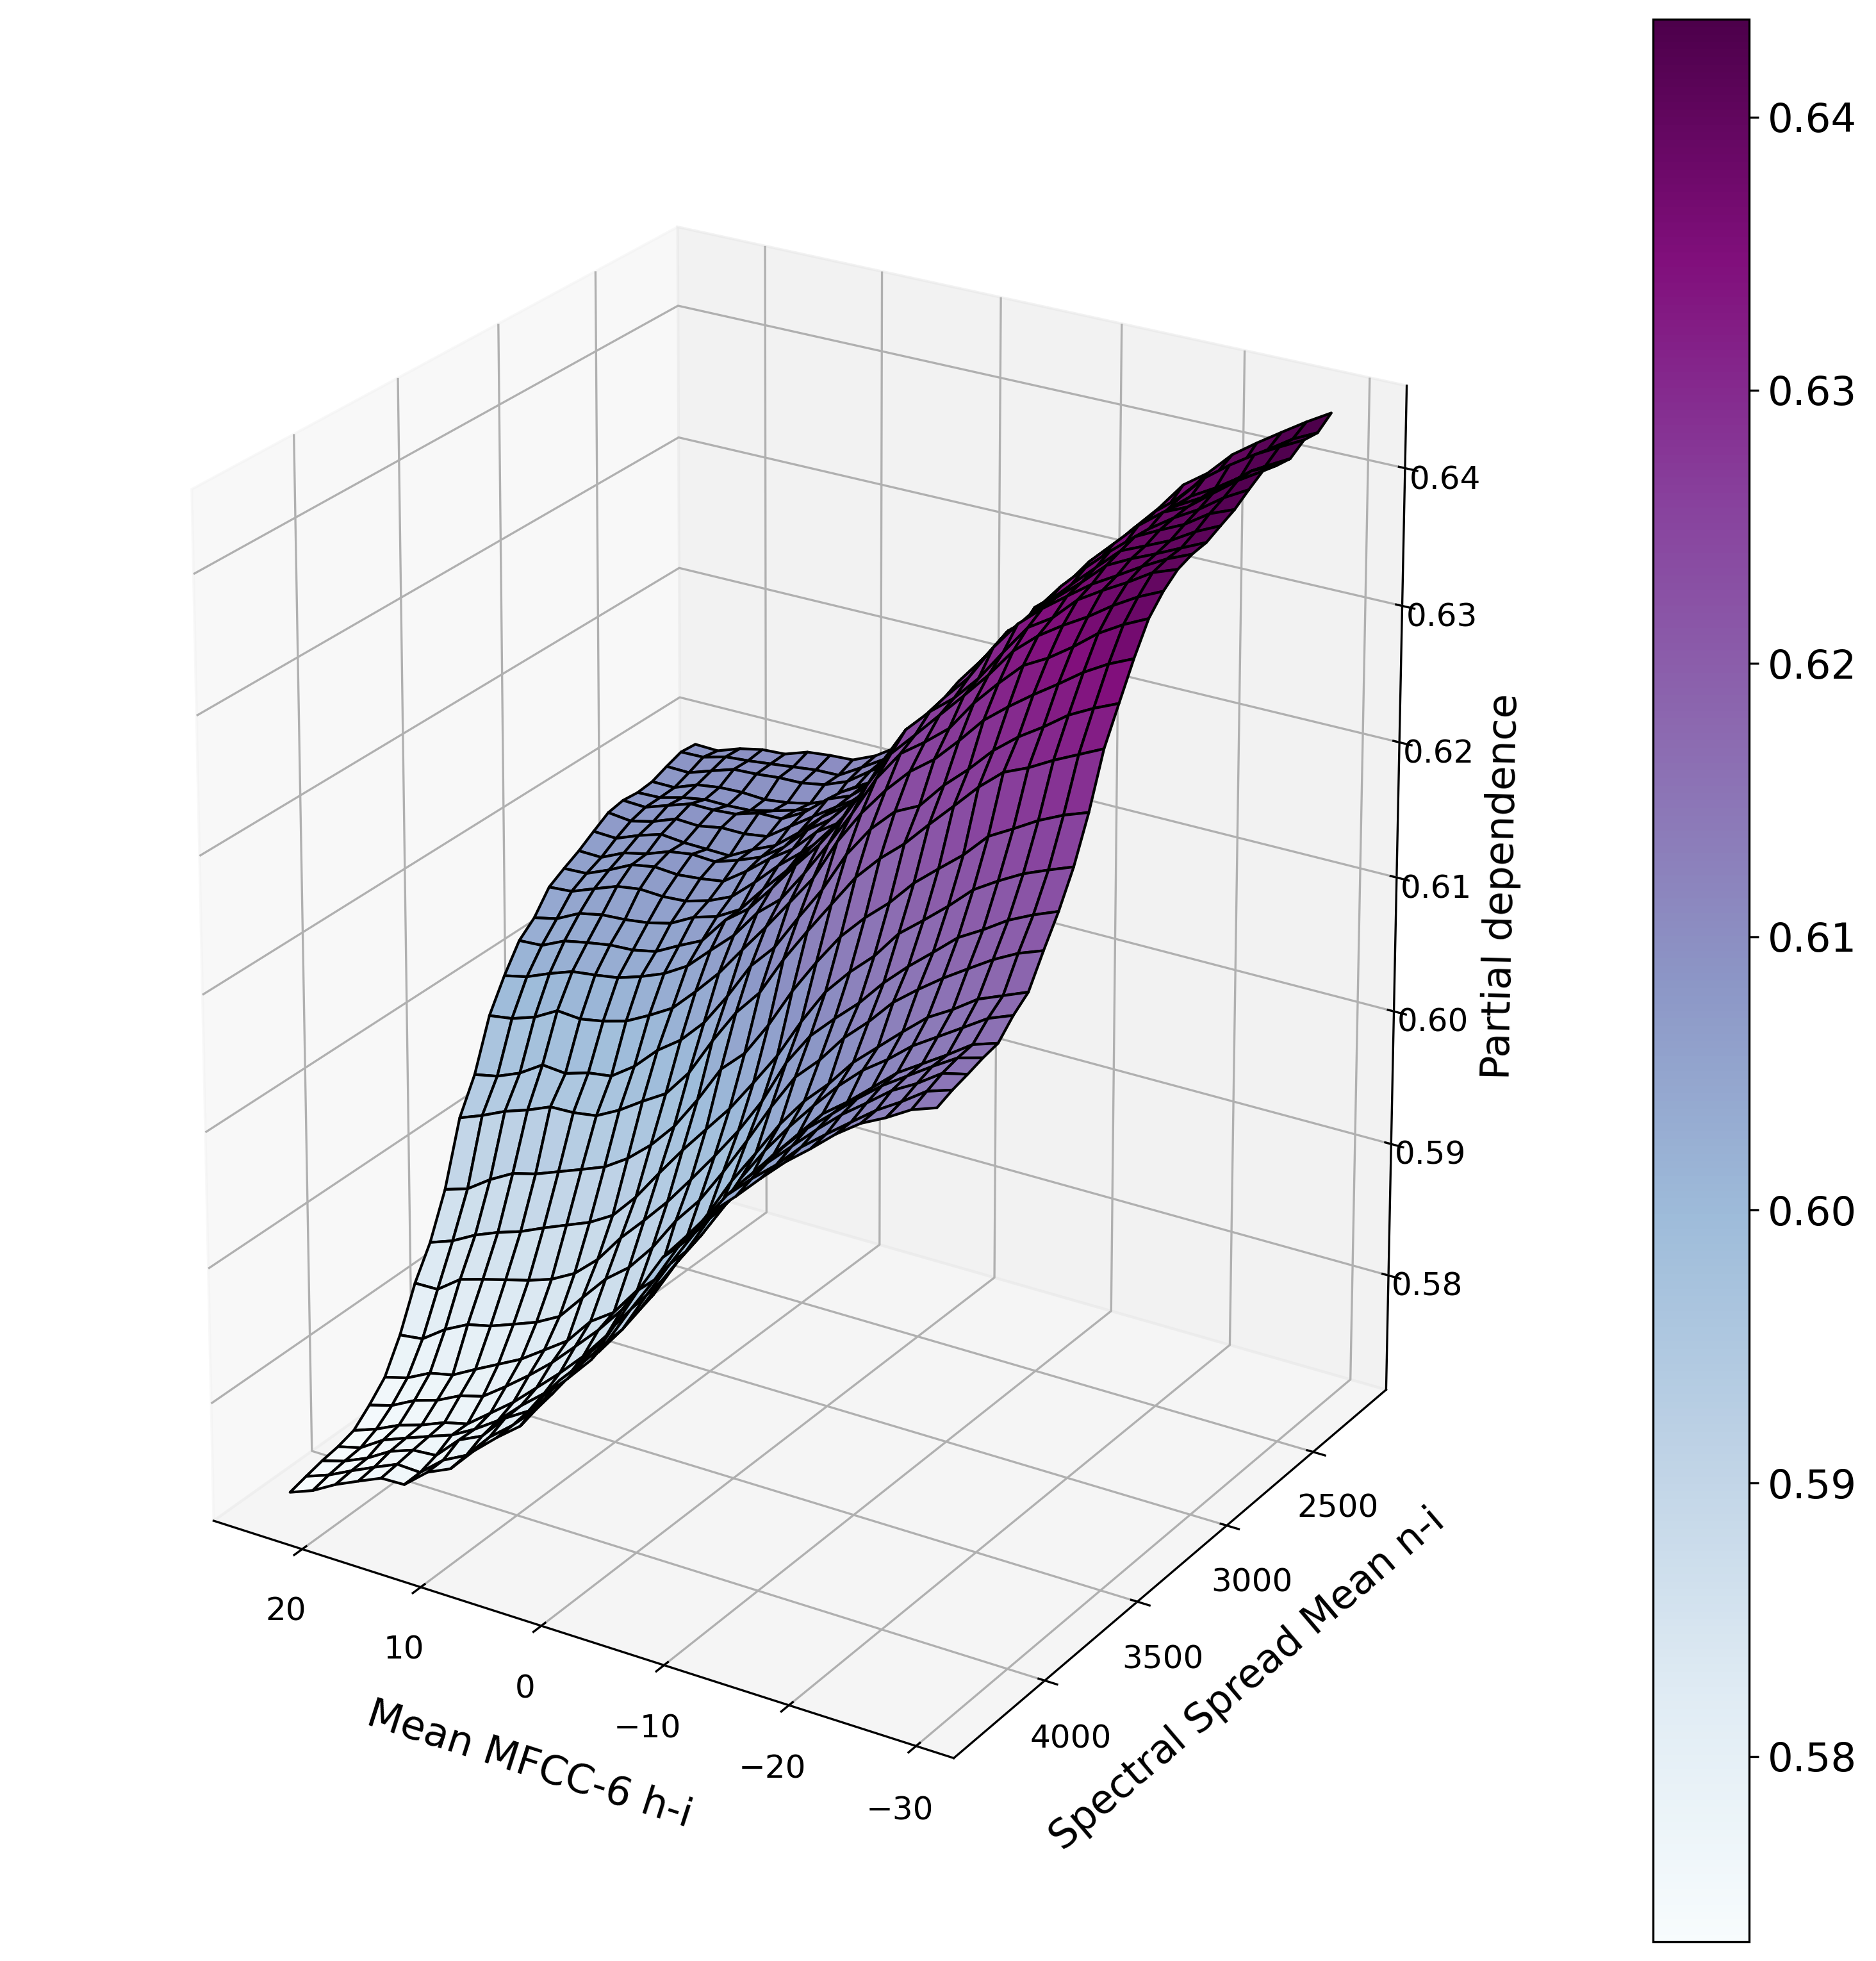

In [15]:
from sklearn.inspection import partial_dependence, plot_partial_dependence
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
rcParams['font.size'] = 15
fig = plt.figure()

features = ('Mean MFCC-6 h-i', 'Spectral Spread Mean n-i')
pdp = partial_dependence(
    tuned_clf, X_test, kind = 'average', features=features, grid_resolution=28
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0], labelpad = 10)
ax.set_ylabel(features[1], labelpad = 10)
ax.set_zlabel('Partial dependence', labelpad = 10)

ax.view_init(elev=20, azim=122)
plt.colorbar(surf)

plt.subplots_adjust(top=0.9)
plt.show()

#### Evaluate performance of the classifier across demographics variables. Note: Only subsets that included at least 20 instances were kept for this analysis.

In [16]:
X = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\Complete_Feature_Set_11_19_2.csv')
y, age, sex, recording_num = X['y'], X['age'], X['sex'], X['recording_num']
X = X.drop(['recording_num','y'], axis = 1)

rfecv_subset = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\RFECV_Results_12_8.csv')
X = X.loc[:, rfecv_subset.columns]

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X = X.drop(X[to_drop], axis=1)
print('Total number of features dropped was...', num_feats_after - X.shape[1], '\nRemaining features... ', X.shape[1])
X = X.drop('high_indexphrase_features', axis = 1)

X = pd.concat([X, sex, age], axis = 1)

Total number of features dropped was... 29 
Remaining features...  75


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify = y, random_state = 42)

mask_s0 = (X_test['sex'] == 0)
mask_s1 = (X_test['sex'] == 1)

mask_s0_age_1 = ((X_test['sex'] == 0) & (X_test['age'] == 1))
mask_s0_age_2 = ((X_test['sex'] == 0) & (X_test['age'] == 2))
mask_s0_age_3 = ((X_test['sex'] == 0) & (X_test['age'] == 3))
mask_s0_age_4 = ((X_test['sex'] == 0) & (X_test['age'] == 4))
mask_s0_age_5 = ((X_test['sex'] == 0) & (X_test['age'] == 5))
mask_s0_age_6 = ((X_test['sex'] == 0) & (X_test['age'] == 6))
mask_s0_age_7 = ((X_test['sex'] == 0) & (X_test['age'] == 7))

mask_s1_age_2 = ((X_test['sex'] == 1) & (X_test['age'] == 2))
mask_s1_age_3 = ((X_test['sex'] == 1) & (X_test['age'] == 3))
mask_s1_age_4 = ((X_test['sex'] == 1) & (X_test['age'] == 4))
mask_s1_age_5 = ((X_test['sex'] == 1) & (X_test['age'] == 5))
mask_s1_age_6 = ((X_test['sex'] == 1) & (X_test['age'] == 6))
mask_s1_age_7 = ((X_test['sex'] == 1) & (X_test['age'] == 7))

X_train = X_train.drop(['sex','age'], axis = 1)
X_test = X_test.drop(['sex','age'], axis = 1)

In [18]:
print('sex: F, age: 10-19\n', classification_report(y_test[mask_s0_age_1], tuned_clf.predict(X_test[mask_s0_age_1]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_1], tuned_clf.predict(X_test[mask_s0_age_1]), average=None))

sex: F, age: 10-19
               precision    recall  f1-score   support

      benign     0.9231    0.9231    0.9231        26
   anomalous     0.3333    0.3333    0.3333         3

    accuracy                         0.8621        29
   macro avg     0.6282    0.6282    0.6282        29
weighted avg     0.8621    0.8621    0.8621        29

0.6282051282051282


In [19]:
print('sex: F, age: 20-29\n', classification_report(y_test[mask_s0_age_2], tuned_clf.predict(X_test[mask_s0_age_2]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s0_age_2], tuned_clf.predict(X_test[mask_s0_age_2]), average=None))

sex: F, age: 20-29
               precision    recall  f1-score   support

      benign     0.8182    0.9101    0.8617        89
   anomalous     0.6667    0.4706    0.5517        34

    accuracy                         0.7886       123
   macro avg     0.7424    0.6904    0.7067       123
weighted avg     0.7763    0.7886    0.7760       123



0.6903502974223398

In [20]:
print('sex: F, age: 30-39\n', classification_report(y_test[mask_s0_age_3], tuned_clf.predict(X_test[mask_s0_age_3]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_3], tuned_clf.predict(X_test[mask_s0_age_3]), average=None))

sex: F, age: 30-39
               precision    recall  f1-score   support

      benign     0.4000    0.6667    0.5000         6
   anomalous     0.9394    0.8378    0.8857        37

    accuracy                         0.8140        43
   macro avg     0.6697    0.7523    0.6929        43
weighted avg     0.8641    0.8140    0.8319        43

0.7522522522522523


In [21]:
print('sex: F, age: 40-49\n', classification_report(y_test[mask_s0_age_4], tuned_clf.predict(X_test[mask_s0_age_4]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s0_age_4], tuned_clf.predict(X_test[mask_s0_age_4]), average=None))

sex: F, age: 40-49
               precision    recall  f1-score   support

      benign     0.1250    0.2500    0.1667         4
   anomalous     0.9118    0.8158    0.8611        38

    accuracy                         0.7619        42
   macro avg     0.5184    0.5329    0.5139        42
weighted avg     0.8368    0.7619    0.7950        42



0.5328947368421053

In [22]:
print('sex: F, age: 50-59\n', classification_report(y_test[mask_s0_age_5], tuned_clf.predict(X_test[mask_s0_age_5]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s0_age_5], tuned_clf.predict(X_test[mask_s0_age_5]), average=None))

sex: F, age: 50-59
               precision    recall  f1-score   support

      benign     0.5000    0.5000    0.5000         4
   anomalous     0.9583    0.9583    0.9583        48

    accuracy                         0.9231        52
   macro avg     0.7292    0.7292    0.7292        52
weighted avg     0.9231    0.9231    0.9231        52



0.7291666666666667

In [23]:
print('sex: F, age: 60-69\n', classification_report(y_test[mask_s0_age_6], tuned_clf.predict(X_test[mask_s0_age_6]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s0_age_6], tuned_clf.predict(X_test[mask_s0_age_6]), average=None))

sex: F, age: 60-69
               precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         1
   anomalous     0.9744    0.9500    0.9620        40

    accuracy                         0.9268        41
   macro avg     0.4872    0.4750    0.4810        41
weighted avg     0.9506    0.9268    0.9386        41



0.475

In [24]:
print('sex: F, age: 70-79\n', classification_report(y_test[mask_s0_age_7], tuned_clf.predict(X_test[mask_s0_age_7]), target_names = ['benign','anomalous'], digits = 4))

sex: F, age: 70-79
               precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         0
   anomalous     1.0000    0.9565    0.9778        23

    accuracy                         0.9565        23
   macro avg     0.5000    0.4783    0.4889        23
weighted avg     1.0000    0.9565    0.9778        23



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [25]:
print('sex: M, age: 20-29\n', classification_report(y_test[mask_s1_age_2], tuned_clf.predict(X_test[mask_s1_age_2]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s1_age_2], tuned_clf.predict(X_test[mask_s1_age_2]), average=None))

sex: M, age: 20-29
               precision    recall  f1-score   support

      benign     0.8387    0.5778    0.6842        45
   anomalous     0.1364    0.3750    0.2000         8

    accuracy                         0.5472        53
   macro avg     0.4875    0.4764    0.4421        53
weighted avg     0.7327    0.5472    0.6111        53



0.47638888888888886

In [26]:
print('sex: M, age: 30-39\n', classification_report(y_test[mask_s1_age_3], tuned_clf.predict(X_test[mask_s1_age_3]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s1_age_3], tuned_clf.predict(X_test[mask_s1_age_3]), average=None))

sex: M, age: 30-39
               precision    recall  f1-score   support

      benign     0.7692    0.7143    0.7407        14
   anomalous     0.7778    0.8235    0.8000        17

    accuracy                         0.7742        31
   macro avg     0.7735    0.7689    0.7704        31
weighted avg     0.7739    0.7742    0.7732        31



0.7689075630252101

In [27]:
print('sex: M, age: 40-49\n', classification_report(y_test[mask_s1_age_4], tuned_clf.predict(X_test[mask_s1_age_4]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s1_age_4], tuned_clf.predict(X_test[mask_s1_age_4]), average=None))

sex: M, age: 40-49
               precision    recall  f1-score   support

      benign     0.5000    0.5000    0.5000         6
   anomalous     0.8800    0.8800    0.8800        25

    accuracy                         0.8065        31
   macro avg     0.6900    0.6900    0.6900        31
weighted avg     0.8065    0.8065    0.8065        31



0.69

In [28]:
print('sex: M, age: 50-59\n', classification_report(y_test[mask_s1_age_5], tuned_clf.predict(X_test[mask_s1_age_5]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s1_age_5], tuned_clf.predict(X_test[mask_s1_age_5]), average=None))

sex: M, age: 50-59
               precision    recall  f1-score   support

      benign     0.4000    0.4000    0.4000         5
   anomalous     0.9400    0.9400    0.9400        50

    accuracy                         0.8909        55
   macro avg     0.6700    0.6700    0.6700        55
weighted avg     0.8909    0.8909    0.8909        55



0.6699999999999999

In [29]:
print('sex: M, age: 60-69\n', classification_report(y_test[mask_s1_age_6], tuned_clf.predict(X_test[mask_s1_age_6]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s1_age_6], tuned_clf.predict(X_test[mask_s1_age_6]), average=None))

sex: M, age: 60-69
               precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         2
   anomalous     0.9592    0.9400    0.9495        50

    accuracy                         0.9038        52
   macro avg     0.4796    0.4700    0.4747        52
weighted avg     0.9223    0.9038    0.9130        52



0.47

In [30]:
print('sex: M, age: 70-79, note: only 1 class has support\n', classification_report(y_test[mask_s1_age_7], tuned_clf.predict(X_test[mask_s1_age_7]), digits = 4))

sex: M, age: 70-79, note: only 1 class has support
               precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        25

    accuracy                         1.0000        25
   macro avg     1.0000    1.0000    1.0000        25
weighted avg     1.0000    1.0000    1.0000        25



In [31]:
print('sex: F\n', classification_report(y_test[mask_s0], tuned_clf.predict(X_test[mask_s0]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s0], tuned_clf.predict(X_test[mask_s0]), average=None))

sex: F
               precision    recall  f1-score   support

      benign     0.7467    0.8550    0.7972       131
   anomalous     0.9073    0.8304    0.8671       224

    accuracy                         0.8394       355
   macro avg     0.8270    0.8427    0.8321       355
weighted avg     0.8480    0.8394    0.8413       355



0.8426594874591057

In [32]:
print('sex: M\n', classification_report(y_test[mask_s1], tuned_clf.predict(X_test[mask_s1]), target_names = ['benign','anomalous'], digits = 4))
(roc_auc_score(y_test[mask_s1], tuned_clf.predict(X_test[mask_s1]), average=None))

sex: M
               precision    recall  f1-score   support

      benign     0.6875    0.5867    0.6331        75
   anomalous     0.8394    0.8901    0.8640       182

    accuracy                         0.8016       257
   macro avg     0.7634    0.7384    0.7485       257
weighted avg     0.7951    0.8016    0.7966       257



0.7383882783882784

### Pickle the model for later use.

In [33]:
pkl_filename = "KNN_1_25_.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(tuned_clf, file)